In [1]:
%load_ext autoreload
%autoreload 2

import util as yu
from util import *
import util_moments as yum

yu.setpath('analysis_c2pt')

projs=['P0', 'Px', 'Py', 'Pz']
inserts=['tt', 'tx', 'ty', 'tz', 'xx', 'xy', 'xz', 'yy', 'yz', 'zz']
enss=['b','c','d','e']

In [2]:
ens2c2pt={}; ens2moms_2pt={}; ens2c2pt0={}; ens2Njk={}
for ens in enss:
    basepath=f'/p/project1/ngff/li47/code/projectData/05_moments/{yu.ens2full[ens]}/data_merge/'
    path=f'{basepath}disc_2pt.h5'
    with h5py.File(path) as f:
        moms_2pt=yu.moms2list(f['moms'])
        c2pt=yu.jackknife(np.real(f['data/N_N'][:,:,:]))
        
    ens2moms_2pt[ens]=moms_2pt
    ens2c2pt[ens]=c2pt
    ens2c2pt0[ens]=c2pt[:,:,moms_2pt.index([0,0,0])]
    ens2Njk[ens]=len(c2pt)

In [3]:
# global parameters
ens2tminss={
        'b':[range(8,25+1),range(1,10+1),range(1,4+1)],
        'c':[range(8,29+1),range(1,16+1),range(1,5+1)],
        'd':[range(8,33+1),range(1,18+1),range(1,6+1)],
        'e':[range(8,39+1),range(1,18+1),range(1,5+1)],
    }
ens2selections={
    'b':{'1st':20,'2st':7,'3st':3},
    'c':{'1st':21,'2st':8,'3st':3},
    'd':{'1st':24,'2st':9,'3st':3},
    'e':{'1st':32,'2st':11,'3st':4},
}

ens2tminss_large={
        'b':[range(8,25+1),range(1,9+1),range(1,1+1)],
        'c':[range(8,29+1),range(1,10+1),range(1,1+1)],
        'd':[range(8,33+1),range(1,11+1),range(1,1+1)],
        'e':[range(8,39+1),range(1,13+1),range(1,1+1)],
    } # used for large momenta

# Analysis for 0 mom

$O(p^2)$ and $O(p^3)$ ChPT corrections:

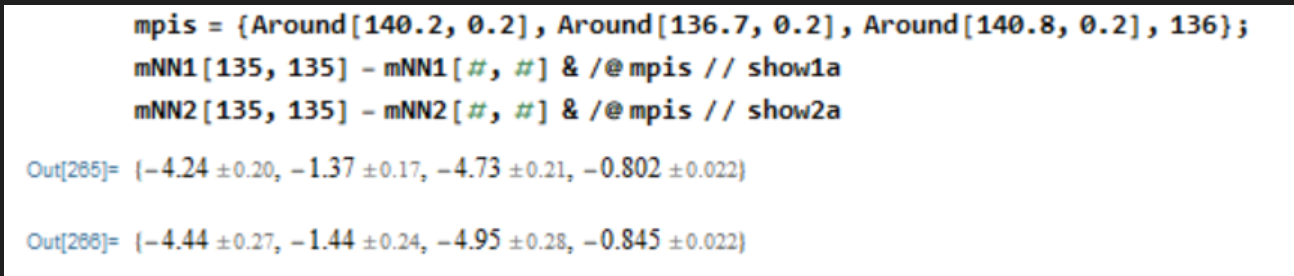

In [4]:
ens2nst={'b':(39.6,1.5),'c':(39.7,1.2),'d':(38.8,2.0)}
# ens2nst={'b':(60,1.5),'c':(60,1.2),'d':(60,2.0)}

ens2DmN_lat={}
for ens in enss[:3]:
    nst=yu.jackknife_pseudo(ens2nst[ens][0],ens2nst[ens][1],ens2Njk[ens])
    amul=yu.ens2amul[ens]; amul_iso=yu.jackknife_pseudo(yu.ens2amul_iso[ens],yu.ens2amul_iso_err[ens],ens2Njk[ens])
    DmN=nst*(amul_iso-amul)/amul
    DmN=DmN[:,0]
    ens2DmN_lat[ens]=DmN
    print(yu.ens2label[ens],yu.jackme_un2str(DmN))

B64 -2.92(19)
C80 -0.90(23)
D96 -3.35(25)


In [5]:
overwrite=False
ens2DmN={'b':(-4.44,0.27),'c':(-1.44,0.24),'d':(-4.95,0.28),'e':(-0.845,0.022)}
ens2DmN={ens:yu.jackknife_pseudo(ens2DmN[ens][0],ens2DmN[ens][1],ens2Njk[ens])[:,0] for ens in enss}

mN_exp=(yu.m_proton+yu.m_neutron)/2

figs=[]; ens2pars_jk_meff1st={}; ens2pars_jk_meff2st={}; ens2pars_jk_meff3st={}
for ens in enss:
    meff=yu.jackmap(yu.c2pt2meff,ens2c2pt0[ens])
    tminss=ens2tminss[ens]

    # tmins=[1.6,0.6,0.2]
    # tmins=[1.6,0.6,0.2]
    # tmins=[t*yu.ens2a['b'] for t in [20,7,3]]
    # selections={f'{i+1}st':yu.find_t_cloest(tmins[i],yu.ens2a[ens]) for i in range(3)}
    selections=ens2selections[ens]
    # selections={}
    print(ens,selections)
    
    fitss_2pt=yu.doFits_meff_nst(meff,tminss,[0.4,0.5,2,0.8,1],downSampling=1,label=f'meff_{ens}',overwrite=overwrite)
    fig,axd,result=yu.makePlot_2pt_SimoneStyle(meff,fitss_2pt,xunit=yu.ens2a[ens],yunit=yu.ens2aInv[ens]/1000,E0_ref=mN_exp/1000,ylims='std_N',\
        selection=selections)
    fig.suptitle(yu.ens2full[ens])
    yu.finalizePlot(closeQ=True)
    figs.append(fig) 
    
    ens2pars_jk_meff1st[ens]=result['1st']
    ens2pars_jk_meff2st[ens]=result['2st']
    ens2pars_jk_meff3st[ens]=result['3st']

enss=['b','c','d']

ens2dats=[{ens:ens2pars_jk_meffnst[ens][:,0]*yu.ens2aInv[ens] for ens in enss} for ens2pars_jk_meffnst in [ens2pars_jk_meff1st,ens2pars_jk_meff2st,ens2pars_jk_meff3st]]
fitss=[yu.doFits_continuumExtrapolation(ens2dat,lat_a2s_plt=yum.lat_a2s_plt) for ens2dat in ens2dats]
matrix_dic=[{
    'ens2dat':ens2dats[ist],
    'fit:[fits,lat_a2s_plt]':[fitss[ist],yum.lat_a2s_plt]
    } for ist in range(len(ens2dats))]
fig,axs=yu.makePlot_continuumExtrapolation(matrix_dic,shows=['MA'])
yu.addColHeader(axs,['1st','2st','3st'])
ax=axs[0,0]
ax.set_ylim([920,960])
ax.set_ylabel(r'$m_N$ [MeV]')
for icol in range(len(matrix_dic)):
    ax=axs[0,icol]
    yu.addRefLine(ax,mN_exp,label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    ax.legend(fontsize=16)  
yu.finalizePlot(closeQ=True)
figs.append(fig)

ens2dats=[{ens:ens2pars_jk_meffnst[ens][:,0]*yu.ens2aInv[ens]+ens2DmN_lat[ens] for ens in enss} for ens2pars_jk_meffnst in [ens2pars_jk_meff1st,ens2pars_jk_meff2st,ens2pars_jk_meff3st]]
fitss=[yu.doFits_continuumExtrapolation(ens2dat,lat_a2s_plt=yum.lat_a2s_plt) for ens2dat in ens2dats]
matrix_dic=[{
    'ens2dat':ens2dats[ist],
    'fit:[fits,lat_a2s_plt]':[fitss[ist],yum.lat_a2s_plt]
    } for ist in range(len(ens2dats))]
fig,axs=yu.makePlot_continuumExtrapolation(matrix_dic,shows=['MA'])
yu.addColHeader(axs,['1st','2st','3st'])
ax=axs[0,0]
ax.set_ylim([920,960])
ax.set_ylabel(r'$m_N$ [MeV]')
for icol in range(len(matrix_dic)):
    ax=axs[0,icol]
    yu.addRefLine(ax,mN_exp,label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    ax.legend(fontsize=16)  
fig.suptitle(r'corrected using lattice $\sigma_{\pi N}$')
yu.finalizePlot(closeQ=True)
figs.append(fig)

ens2dats=[{ens:ens2pars_jk_meffnst[ens][:,0]*yu.ens2aInv[ens]+ens2DmN[ens] for ens in enss} for ens2pars_jk_meffnst in [ens2pars_jk_meff1st,ens2pars_jk_meff2st,ens2pars_jk_meff3st]]
fitss=[yu.doFits_continuumExtrapolation(ens2dat,lat_a2s_plt=yum.lat_a2s_plt) for ens2dat in ens2dats]
matrix_dic=[{
    'ens2dat':ens2dats[ist],
    'fit:[fits,lat_a2s_plt]':[fitss[ist],yum.lat_a2s_plt]
    } for ist in range(len(ens2dats))]
fig,axs=yu.makePlot_continuumExtrapolation(matrix_dic,shows=['MA'])
yu.addColHeader(axs,['1st','2st','3st'])
ax=axs[0,0]
ax.set_ylim([920,960])
ax.set_ylabel(r'$m_N$ [MeV]')
for icol in range(len(matrix_dic)):
    ax=axs[0,icol]
    yu.addRefLine(ax,mN_exp,label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    ax.legend(fontsize=16)  
fig.suptitle(r'corrected using $O(p^3)$ ChPT')
yu.finalizePlot(closeQ=True)
figs.append(fig)

enss=['b','c','d','e']
    
yu.makePDF('meff',figs)

label=f'ens2pars_jk_meffnst_selected'
yu.save_pkl_reg(label,[ens2pars_jk_meff1st,ens2pars_jk_meff2st,ens2pars_jk_meff3st])

b {'1st': 20, '2st': 7, '3st': 3}
c {'1st': 21, '2st': 8, '3st': 3}
d {'1st': 24, '2st': 9, '3st': 3}
e {'1st': 32, '2st': 11, '3st': 4}


# All msq/mom (fit guided by 0 mom [done below])

In [6]:
# check error

def mom2num(mom):
    moms=yu.mom2moms(mom)
    return len(moms)

for ens in ['b']:
    c2pt=ens2c2pt[ens]
    moms=ens2moms_2pt[ens]
    msqs=[yu.mom2msq(mom) for mom in moms]
    msqs_unique=yu.removeDuplicates(msqs)
    msqs_do=[msq for msq in msqs_unique if msq<=25]
    
    for msq in msqs_do:
        inds=np.where(msqs==msq)[0]
        if len(inds)>1:
            ts=[5,15,25,35]
            c0=c2pt[:,ts,inds[0]]
            c1=c2pt[:,ts,inds[1]]
            
            m0=moms[inds[0]]; m1=moms[inds[1]]
            n0=mom2num(m0); n1=mom2num(m1)
            print(f'{m0} ({n0}); {m1} ({n1})')
            print(yu.jackme_un2str(c0))
            print(yu.jackme_un2str(c1))
            print(yu.jackme_un2str((c0+c1)/2))
            print(yu.jackme_un2str((c0*n0+c1*n1)/(n0+n1)))
            print()
    break

[0, 0, 3] (6); [1, 2, 2] (24)
[0.00000000083899(86), 0.000000000005316(21), 0.0000000000000358(43), 0.0000000000000002(16)]
[0.00000000083819(86), 0.000000000005288(19), 0.0000000000000407(27), 0.00000000000000201(87)]
[0.00000000083859(86), 0.000000000005302(19), 0.0000000000000383(27), 0.00000000000000110(94)]
[0.00000000083835(86), 0.000000000005294(19), 0.0000000000000397(24), 0.00000000000000165(79)]

[0, 1, 4] (24); [2, 2, 3] (24)
[0.00000000028984(33), 0.0000000000008694(88), 0.0000000000000040(16), -0.00000000000000023(53)]
[0.00000000028908(33), 0.0000000000008582(84), 0.0000000000000017(15), -0.00000000000000046(51)]
[0.00000000028946(33), 0.0000000000008638(73), 0.0000000000000029(12), -0.00000000000000034(37)]
[0.00000000028946(33), 0.0000000000008638(73), 0.0000000000000029(12), -0.00000000000000034(37)]

[1, 1, 4] (24); [0, 3, 3] (12)
[0.00000000025494(30), 0.0000000000007026(74), 0.0000000000000032(13), -0.00000000000000030(46)]
[0.00000000025449(30), 0.0000000000006968(

In [7]:
def run(ens):
    c2pt=ens2c2pt[ens]
    moms=ens2moms_2pt[ens]
    moms_sort=sorted(moms,key=yu.getSortkey_mom)
    
    # for mom in moms_sort:
    #     print(mom,yu.find_fitmax(c2pt[:,:,moms.index(mom)]))
    
    meff0=yu.jackmap(yu.c2pt2meff,c2pt[:,:,moms.index([0,0,0])])
    tmax=yu.find_fitmax(meff0)
    tmin=ens2selections[ens]['2st']
    ts=np.arange(tmin,tmax)
    y_jk=meff0[:,ts]
    def fitfunc(pars):
        return yu.func_meff_2st(ts,*pars)
    pars0=[0.3,0.2,0.8]
    pars_jk_0mom,chi2_jk,Ndof,Nwarning=yu.jackfit(fitfunc,y_jk,pars0)
    
    fitss=yu.load_pkl_reg('ens2pars_jk_meffnst_selected')
    if fitss is not None:
        [ens2pars_jk_meff1st,ens2pars_jk_meff2st,ens2pars_jk_meff3st]=fitss
        print(ens,yu.jackme_un2str(pars_jk_0mom),yu.jackme_un2str(ens2pars_jk_meff2st[ens]))
        
    msqs=[yu.mom2msq(mom) for mom in moms]
    msqs_unique=yu.removeDuplicates(msqs)
    msqs_do=[msq for msq in msqs_unique if msq<=25]
    
    msq2pars_jk={}
    pars0=np.mean(pars_jk_0mom,axis=0)[1:]
    for msq in msqs_do:
        inds=np.where(np.array(msqs)==msq)[0]
        Ns=[mom2num(moms[ind]) for ind in inds]
        weights=np.array(Ns)/np.sum(Ns)
        
        t_c2pt=np.sum([c2pt[:,:,ind]*weights[i] for i,ind in enumerate(inds)],axis=0)

        parsExtra_jk=np.sqrt(pars_jk_0mom[:,:1]**2 + (2*np.pi/yu.ens2NL[ens])**2 * msq)
        def fitfunc(pars):
            dE1,rc1, E0=pars
            return yu.func_meff_2st(ts,E0,dE1,rc1)
        
        meff=yu.jackmap(yu.c2pt2meff,t_c2pt)
        tmax=yu.find_fitmax(meff)
        tmin=ens2selections[ens]['2st']
        ts=np.arange(tmin,tmax)
        y_jk=meff[:,ts]
        pars_jk,chi2_jk,Ndof,Nwarning=yu.jackfit(fitfunc,y_jk,pars0,parsExtra_jk=parsExtra_jk)
        pars0=np.mean(pars_jk,axis=0)
        
        pars_jk=np.concatenate([parsExtra_jk,pars_jk],axis=1)
        msq2pars_jk[msq]=pars_jk
        
        # print(mom,yu.jackme_un2str(pars_jk))
    
    return msq2pars_jk

enss_do=enss[:3]
ens2msq2pars_jk=yu.load_pkl_reg('ens2msq2pars_jk')
if ens2msq2pars_jk is None:
    ens2msq2pars_jk={ens:{} for ens in enss_do}
    for ens in enss_do:
        ens2msq2pars_jk[ens]=run(ens)
    yu.save_pkl_reg('ens2msq2pars_jk',ens2msq2pars_jk)

b [0.3809(13), 0.232(16), 0.846(21)] [0.3809(13), 0.232(16), 0.846(21)]
c [0.3260(11), 0.203(15), 0.700(20)] [0.3260(11), 0.203(15), 0.700(20)]
d [0.27272(90), 0.189(13), 0.821(25)] [0.27272(90), 0.189(13), 0.821(25)]


In [8]:
def run(ens):
    c2pt=ens2c2pt[ens]
    moms=ens2moms_2pt[ens]
    moms_sort=sorted(moms,key=yu.getSortkey_mom)
    
    meff0=yu.jackmap(yu.c2pt2meff,c2pt[:,:,moms.index([0,0,0])])
    tmax=yu.find_fitmax(meff0)
    tmin=ens2selections[ens]['2st']
    ts=np.arange(tmin,tmax)
    y_jk=meff0[:,ts]
    def fitfunc(pars):
        return yu.func_meff_2st(ts,*pars)
    pars0=[0.3,0.2,0.8]
    pars_jk_0mom,chi2_jk,Ndof,Nwarning=yu.jackfit(fitfunc,y_jk,pars0)
    
    fitss=yu.load_pkl_reg('ens2pars_jk_meffnst_selected')
    if fitss is not None:
        [ens2pars_jk_meff1st,ens2pars_jk_meff2st,ens2pars_jk_meff3st]=fitss
        print(ens,yu.jackme_un2str(pars_jk_0mom),yu.jackme_un2str(ens2pars_jk_meff2st[ens]))
    
    mom2pars_jk={}
    moms_do=moms_sort[:27] 
    pars0=np.mean(pars_jk_0mom,axis=0)[1:]
    for i in range(len(moms_do)):
        mom=moms_do[i]
        msq=yu.mom2msq(mom)
        parsExtra_jk=np.sqrt(pars_jk_0mom[:,:1]**2 + (2*np.pi/yu.ens2NL[ens])**2 * msq)
        def fitfunc(pars):
            dE1,rc1, E0=pars
            return yu.func_meff_2st(ts,E0,dE1,rc1)
        
        meff=yu.jackmap(yu.c2pt2meff,c2pt[:,:,moms.index(mom)])
        tmax=yu.find_fitmax(meff)
        tmin=ens2selections[ens]['2st']
        ts=np.arange(tmin,tmax)
        y_jk=meff[:,ts]
        pars_jk,chi2_jk,Ndof,Nwarning=yu.jackfit(fitfunc,y_jk,pars0,parsExtra_jk=parsExtra_jk)
        pars0=np.mean(pars_jk,axis=0)
        
        pars_jk=np.concatenate([parsExtra_jk,pars_jk],axis=1)
        mom2pars_jk[tuple(mom)]=pars_jk
        
        # print(mom,yu.jackme_un2str(pars_jk))
    
    return mom2pars_jk

enss_do=enss[:3]
ens2mom2pars_jk=yu.load_pkl_reg('ens2mom2pars_jk')
if ens2mom2pars_jk is None:
    ens2mom2pars_jk={ens:{} for ens in enss_do}
    for ens in enss_do:
        ens2mom2pars_jk[ens]=run(ens)
    yu.save_pkl_reg('ens2mom2pars_jk',ens2mom2pars_jk)

b [0.3809(13), 0.232(16), 0.846(21)] [0.3809(13), 0.232(16), 0.846(21)]
c [0.3260(11), 0.203(15), 0.700(20)] [0.3260(11), 0.203(15), 0.700(20)]
d [0.27272(90), 0.189(13), 0.821(25)] [0.27272(90), 0.189(13), 0.821(25)]


In [9]:
fig,axs=yu.getFigAxs(2,len(enss_do),Lrow=4,Lcol=8,sharex=True,sharey='row')
yu.addColHeader(axs,[yu.ens2label[ens] for ens in enss_do])

axs[0,0].set_ylabel(r'$E_{0,1}(\vec{p})$ [GeV]')    
axs[1,0].set_ylabel(r'$rc1$')    
for iens,ens in enumerate(enss_do):
    yunit=yu.ens2aInv[ens]/1000
    mom2pars_jk=ens2mom2pars_jk[ens]
    moms=[tuple(mom) for mom in sorted(list(mom2pars_jk.keys()),key=yu.getSortkey_mom)]
    msqs=[yu.mom2msq(mom) for mom in moms]
    
    ax=axs[0,iens]
    
    t=np.transpose([mom2pars_jk[mom][:,0] for mom in moms])
    mean,err=yu.jackme(t)
    plt_x=msqs; plt_y=mean*yunit; plt_yerr=err*yunit
    plt_x=yu.jitter_duplicate_x(plt_x,fraction=0.4)
    ax.errorbar(plt_x,plt_y,plt_yerr,color='r',mfc='white')
    
    msqs_plt=np.arange(0,msqs[-1]+0.1,0.5)
    Es0=mom2pars_jk[(0,0,0)][:,0]
    Es_plt=np.transpose([np.sqrt(Es0**2+(2*np.pi/yu.ens2NL[ens])**2 * msq) for msq in msqs_plt])
    mean,err=yu.jackme(Es_plt*yunit)
    x=msqs_plt; ymin=mean-err; ymax=mean+err
    ax.plot(x,mean,color='r',linestyle='--',marker='')
    ax.fill_between(x, ymin, ymax, color='r', alpha=0.2)
    
    t=np.transpose([mom2pars_jk[mom][:,0]+mom2pars_jk[mom][:,1] for mom in moms])
    mean,err=yu.jackme(t)
    plt_x=msqs; plt_y=mean*yunit; plt_yerr=err*yunit
    plt_x=yu.jitter_duplicate_x(plt_x,fraction=0.4)
    ax.errorbar(plt_x,plt_y,plt_yerr,color='b',mfc='white')
    
    msqs_plt=np.arange(0,msqs[-1]+0.1,0.5)
    Es0=mom2pars_jk[(0,0,0)][:,0]+mom2pars_jk[(0,0,0)][:,1]
    Es_plt=np.transpose([np.sqrt(Es0**2+(2*np.pi/yu.ens2NL[ens])**2 * msq) for msq in msqs_plt])
    mean,err=yu.jackme(Es_plt*yunit)
    x=msqs_plt; ymin=mean-err; ymax=mean+err
    ax.plot(x,mean,color='b',linestyle='--',marker='')
    ax.fill_between(x, ymin, ymax, color='b', alpha=0.2)
    
    ax=axs[1,iens]
    ax.set_xlabel('msq')
    
    t=np.transpose([mom2pars_jk[mom][:,2] for mom in moms])
    mean,err=yu.jackme(t)
    plt_x=msqs; plt_y=mean; plt_yerr=err
    plt_x=yu.jitter_duplicate_x(plt_x,fraction=0.4)
    ax.errorbar(plt_x,plt_y,plt_yerr,color='b',mfc='white')

for iens,ens in enumerate(enss_do):
    yunit=yu.ens2aInv[ens]/1000
    msq2pars_jk=ens2msq2pars_jk[ens]
    msqs=list(msq2pars_jk.keys()); msqs.sort()
    
    ax=axs[0,iens]
    
    t=np.transpose([msq2pars_jk[msq][:,0] for msq in msqs])
    mean,err=yu.jackme(t)
    plt_x=msqs; plt_y=mean*yunit; plt_yerr=err*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
    
    t=np.transpose([msq2pars_jk[msq][:,0]+msq2pars_jk[msq][:,1] for msq in msqs])
    mean,err=yu.jackme(t)
    plt_x=msqs; plt_y=mean*yunit; plt_yerr=err*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
    
    ax=axs[1,iens]
    
    t=np.transpose([msq2pars_jk[msq][:,2] for msq in msqs])
    mean,err=yu.jackme(t)
    plt_x=msqs; plt_y=mean; plt_yerr=err
    ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
    
yu.finalizePlot('GuidedFit_2st_allmom')

# All momenta (verify dispersion relation)

In [10]:
overwrite=False
def run(ens,mom):
    moms_2pt=ens2moms_2pt[ens]
    meff=yu.jackmap(yu.c2pt2meff,ens2c2pt[ens][:,:,moms_2pt.index(mom)])
    
    tminss=ens2tminss[ens]
    selections=ens2selections[ens].copy()
    
    msq=mom[0]**2+mom[1]**2+mom[2]**2
    E0_ref=np.sqrt(yu.m_avgpn**2+ (2*np.pi/yu.ens2NL[ens]*yu.ens2aInv[ens])**2 * msq )/1000
    
    if msq>4:
        del selections['1st']
        del selections['3st']
        tminss=ens2tminss_large[ens]
    
    fitss_2pt=yu.doFits_meff_nst(meff,tminss,[0.4,0.5,2,0.8,1],downSampling=1,label=f'meff_{ens}_{yu.mom2str(mom)}',overwrite=overwrite)
    fig,axd,result=yu.makePlot_2pt_SimoneStyle(meff,fitss_2pt,xunit=yu.ens2a[ens],yunit=yu.ens2aInv[ens]/1000,E0_ref=E0_ref,ylims='auto',\
        selection=selections,labelType='EN')
    fig.suptitle(rf'{yu.ens2label[ens]}; $\vec{{p}}=${mom}')
    yu.finalizePlot(closeQ=True)

    return fig,result


ens2nst2mom2pars={}

nsts=['1st','2st','3st']
for ens in enss[:3]:
    moms=sorted(ens2moms_2pt[ens],key=yu.getSortkey_mom)
    moms=[mom for mom in moms if yu.mom2msq(mom)<=20]
    msqs=np.array([yu.mom2msq(mom) for mom in moms])
    
    nst2mom2pars={nst:{} for nst in nsts}
    
    figs=[]
    for imom, mom in enumerate(moms):
        print(ens,f'{imom}/{len(moms)}',mom,end='               \r')
        fig,result=run(ens,mom)
        figs.append(fig)
        for nst in nsts:
            nst2mom2pars[nst][tuple(mom)]=result[nst]
    
    ENs=np.transpose([nst2mom2pars['2st'][tuple(mom)][:,0] for mom in moms])
    
    fig,axs=yu.getFigAxs(1,1)
    ax=axs[0,0]
    yunit=yu.ens2aInv[ens]/1000
    ax.set_xlabel('msq')
    ax.set_ylabel(r'$E_N(\vec{p})$')    
    
    mean,err=yu.jackme(ENs)
    plt_x=msqs; plt_y=mean*yunit; plt_yerr=err*yunit
    plt_x=yu.jitter_duplicate_x(plt_x)
    ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
    
    msqs_plt=np.arange(0,msqs[-1]+0.1,0.5)
    mN=ENs[:,0]
    ENs_plt=np.transpose([np.sqrt(mN**2+(2*np.pi/yu.ens2NL[ens])**2 * msq) for msq in msqs_plt])
    mean,err=yu.jackme(ENs_plt*yunit)
    
    x=msqs_plt; ymin=mean-err; ymax=mean+err
    ax.plot(x,mean,color='r',linestyle='--',marker='')
    ax.fill_between(x, ymin, ymax, color='r', alpha=0.2)
    yu.finalizePlot(closeQ=True)
    figs.insert(0,fig)
    
    yu.makePDF(f'Eeff_{ens}',figs)
    
    ens2nst2mom2pars[ens]=nst2mom2pars.copy()
    
yu.save_pkl_reg('ens2nst2mom2pars',ens2nst2mom2pars)